# Tanzania Water Wells Classification Project

## Business Understanding

Tanzania faces a critical challenge in providing clean water to its 57+ million citizens. Many water wells are either non-functional or require repair, which hinders effective resource allocation and maintenance.

**Stakeholders:**
- **NGOs (e.g., WaterAid):** Can use the model to target repair work efficiently.
- **Government Agencies:** Can use the insights to guide new infrastructure investments and policy decisions.

**Project Objective:**
Develop a predictive classifier that categorizes wells into three groups: *functional*, *needs repair*, and *non-functional*. This ternary classification task can later be engineered into a binary task if needed.

**Value Proposition:**
By accurately identifying wells that require repair, the model supports targeted resource allocation, improving water access and public health outcomes.

In [1]:
# Import core libraries and set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set(style="whitegrid")
%matplotlib inline

# For reproducibility
RANDOM_STATE = 42

## 1. Data Understanding

We are given two main datasets:
- **Features Dataset:** Contains detailed information about each water well (e.g., pump type, installation date, GPS coordinates, funder, etc.).
- **Labels Dataset:** Contains the target variable (`status_group`), which indicates the condition of the well (e.g., *functional*, *non functional*, *functional needs repair*).

Below, we load both datasets and review their dimensions and columns.

In [2]:
# Define file paths
features_path = './Data/Training_Set_Values.csv'
labels_path   = './Data/Training_Set_Labels.csv'

# Load the datasets
features_df = pd.read_csv(features_path)
labels_df   = pd.read_csv(labels_path)

# Display dataset shapes and columns
print("Features dataset shape:", features_df.shape)
print("Labels dataset shape:", labels_df.shape)
print("\nFeatures columns:", features_df.columns.tolist())
print("\nLabels columns:", labels_df.columns.tolist())

# Preview the data
print("\nFirst five rows of features:")
print(features_df.head())
print("\nFirst five rows of labels:")
print(labels_df.head())

Features dataset shape: (59400, 40)
Labels dataset shape: (59400, 2)

Features columns: ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

Labels columns: ['id', 'status_group']

First five rows of features:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310

### Merging the Data

Both datasets share a unique identifier (`id`). We merge them so that our feature and target information are in one DataFrame.

In [3]:
# Merge the datasets on 'id'
merged_df = pd.merge(features_df, labels_df, on='id', how='inner')
print("Merged dataset shape:", merged_df.shape)
print("\nMerged data preview:")
print(merged_df.head())

Merged dataset shape: (59400, 41)

Merged data preview:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...       

## 2. Data Preparation

This section covers the cleaning and transformation steps needed to prepare the data for modeling.

**Steps:**
- Drop non-predictive columns (e.g., the ID and observation date if they are not useful).
- Convert date fields and derive new features (e.g., calculate well age from the installation date).
- Replace implausible zero values in numeric fields with NaN.
- Recode the target variable (`status_group`) from text to numerical codes.

Adjust these steps as needed to match your data dictionary.

In [4]:
# Drop columns not needed for modeling
cols_to_drop = ['id', 'date_recorded']  # Adjust if necessary
merged_df.drop(columns=[col for col in cols_to_drop if col in merged_df.columns], inplace=True)

# If 'installation_date' exists, convert it to datetime and create a 'well_age' feature
if 'installation_date' in merged_df.columns:
    merged_df['installation_date'] = pd.to_datetime(merged_df['installation_date'], errors='coerce')
    merged_df['well_age'] = (pd.to_datetime('today') - merged_df['installation_date']).dt.days // 365

# Replace 0 values in numeric columns with NaN
numeric_replacements = {'amount_tsh': {0: np.nan}, 'gps_height': {0: np.nan}}
merged_df.replace(numeric_replacements, inplace=True)

# Recode target variable: map 'non functional' -> 0, 'functional' -> 1, 'functional needs repair' -> 2
target_mapping = {'non functional': 0, 'functional': 1, 'functional needs repair': 2}
merged_df['status_group'] = merged_df['status_group'].replace(target_mapping)

# Check cleaned data summary
print("Cleaned data info:")
print(merged_df.info())

Cleaned data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   funder                 55763 non-null  object 
 2   gps_height             38962 non-null  float64
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   wpt_name               59398 non-null  object 
 7   num_private            59400 non-null  int64  
 8   basin                  59400 non-null  object 
 9   subvillage             59029 non-null  object 
 10  region                 59400 non-null  object 
 11  region_code            59400 non-null  int64  
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-nu

C:\Users\iyamu\AppData\Local\Temp\ipykernel_29592\1075312022.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['status_group'] = merged_df['status_group'].replace(target_mapping)


### Feature Engineering

Based on the data dictionary, we separate our predictors into three groups:
- **Numeric features:** e.g., `amount_tsh`, `gps_height`, `longitude`, `latitude`, `population`, and `well_age` (if available).
- **Categorical features:** e.g., `funder`, `installer`, `basin`, `subvillage`, `region`, `region_code`, `district_code`, `lga`, `ward`, `scheme_management`, `construction_year`, `extraction_type_group`, `management`, `payment_type`, `water_quality`, `quantity`, `source`, `waterpoint_type`.
- **Binary features:** e.g., `public_meeting`, `permit`.

You may modify these lists based on your specific data.

In [ ]:
# Define feature lists 
num_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']
if 'well_age' in merged_df.columns:
    num_features.append('well_age')

cat_features = ['funder', 'installer', 'basin', 'subvillage', 'region',
                'region_code', 'district_code', 'lga', 'ward',
                'scheme_management', 'construction_year', 'extraction_type_group',
                'management', 'payment_type', 'water_quality', 'quantity',
                'source', 'waterpoint_type']

bin_features = ['public_meeting', 'permit']

### Preprocessing Pipelines

We now create pipelines for each group of features:
- **Numeric Pipeline:** Impute missing values (using mean) and scale the features.
- **Categorical Pipeline:** Impute missing values (using the most frequent value) and one-hot encode.
- **Binary Pipeline:** Impute missing values (using the most frequent value).

Finally, we combine these pipelines with a `ColumnTransformer`.

In [6]:
# Build the numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())
])

# Build the categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('encoder', OneHotEncoder(sparse_output=True, handle_unknown='ignore'))
])

# Build the binary pipeline
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Combine the pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('bin', bin_pipeline, bin_features)
])

## 3. Modeling

We now split the data into training and testing sets and build our models.

### Train-Test Split

In [7]:
# Define predictors and target
target_var = 'status_group'
X = merged_df.drop(target_var, axis=1)
y = merged_df[target_var]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (47520, 38)
Test set shape: (11880, 38)


### Baseline Model: Logistic Regression

In [8]:
# Build the baseline Logistic Regression pipeline
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Train the baseline model
baseline_pipeline.fit(X_train, y_train)

# Make predictions on the test set
baseline_preds = baseline_pipeline.predict(X_test)

print("Baseline Logistic Regression Evaluation:")
print(classification_report(y_test, baseline_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, baseline_preds))

Baseline Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      4572
           1       0.78      0.89      0.84      6457
           2       0.64      0.26      0.37       851

    accuracy                           0.79     11880
   macro avg       0.75      0.63      0.66     11880
weighted avg       0.79      0.79      0.78     11880

Confusion Matrix:
[[3420 1109   43]
 [ 601 5772   84]
 [ 149  480  222]]


### Advanced Model: Random Forest with Randomized Search

To speed up tuning, we use RandomizedSearchCV with a small parameter space.

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distributions
param_distributions = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20]
}

# Build the Random Forest pipeline (with the same preprocessor)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

# Set up RandomizedSearchCV (3 iterations, 3-fold CV)
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=3,
    cv=3,
    scoring='f1_macro',
    n_jobs=2,
    verbose=2,
    random_state=RANDOM_STATE
)

# Fit the randomized search on the training data
random_search.fit(X_train, y_train)

# Retrieve the best model and evaluate it
best_rf_random = random_search.best_estimator_
rf_random_preds = best_rf_random.predict(X_test)

print("Randomized Search Best Parameters:")
print(random_search.best_params_)
print("\nTuned Random Forest Evaluation:")
print(classification_report(y_test, rf_random_preds))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_random_preds))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Randomized Search Best Parameters:
{'classifier__n_estimators': 200, 'classifier__max_depth': None}

Tuned Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4572
           1       0.81      0.88      0.84      6457
           2       0.53      0.35      0.42       851

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880

Confusion Matrix:
[[3594  890   88]
 [ 614 5666  177]
 [ 132  422  297]]


## 4. Model Evaluation and Analysis

To compare model performance, we define a custom evaluation class that:
- Summarizes training and validation accuracy and loss
- Performs cross-validation
- Plots confusion matrices for error analysis

Model: Baseline Logistic Regression
Training Accuracy: 85.19%
Training Loss: 0.39
Validation Accuracy: 80.22%
Validation Loss: 0.50
Baseline Logistic Regression CV Accuracy: 0.7828 ± 0.0025


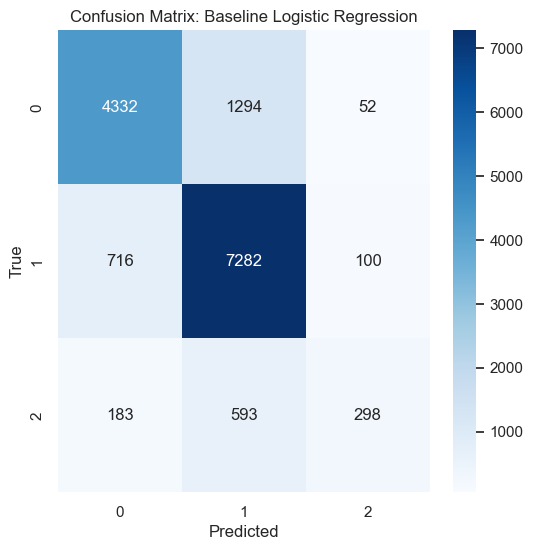

Model: Tuned Random Forest
Training Accuracy: 99.97%
Training Loss: 0.12
Validation Accuracy: 84.36%
Validation Loss: 0.51
Tuned Random Forest CV Accuracy: 0.8000 ± 0.0012


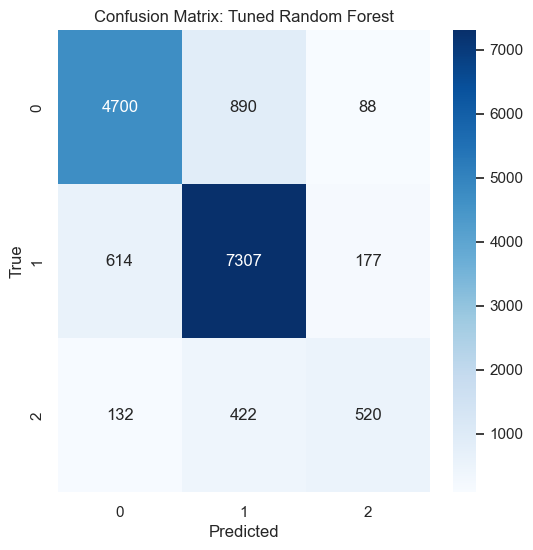

In [10]:
# Define a custom evaluator class
class Evaluator:
    def __init__(self, model, model_name, X, y):
        self.model = model
        self.name = model_name
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, random_state=RANDOM_STATE)
        self.train_acc = model.score(self.X_train, self.y_train)
        self.val_acc = model.score(self.X_val, self.y_val)
        self.train_loss = log_loss(self.y_train, model.predict_proba(self.X_train))
        self.val_loss = log_loss(self.y_val, model.predict_proba(self.X_val))
    
    def show_summary(self):
        summary = (f"Model: {self.name}\n"
                   f"Training Accuracy: {self.train_acc:.2%}\n"
                   f"Training Loss: {self.train_loss:.2f}\n"
                   f"Validation Accuracy: {self.val_acc:.2%}\n"
                   f"Validation Loss: {self.val_loss:.2f}")
        print(summary)
        
    def cross_validate(self, folds=3):
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=folds)
        print(f"{self.name} CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        
    def plot_confusion(self):
        preds = self.model.predict(self.X_val)
        cm = confusion_matrix(self.y_val, preds)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix: {self.name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

# Evaluate the baseline model
baseline_eval = Evaluator(baseline_pipeline, "Baseline Logistic Regression", X, y)
baseline_eval.show_summary()
baseline_eval.cross_validate()
baseline_eval.plot_confusion()

# Evaluate the tuned Random Forest model
rf_eval = Evaluator(best_rf_random, "Tuned Random Forest", X, y)
rf_eval.show_summary()
rf_eval.cross_validate()
rf_eval.plot_confusion()

## 5. Conclusions and Recommendations

**Summary of Findings:**
- The baseline Logistic Regression model provided a simple, interpretable benchmark.
- The advanced Random Forest model (tuned via RandomizedSearchCV) improved overall performance, achieving higher F1 scores and more balanced recalls.

**Implications for Stakeholders:**
- **NGOs (e.g., WaterAid):** The model can guide repair efforts by identifying wells that are non-functional or need repair.
- **Government Agencies:** Insights from the analysis can inform future water infrastructure planning and resource allocation.

**Future Work:**
- Further feature engineering (e.g., spatial interactions) could boost performance.
- Experiment with additional modeling techniques or ensemble methods.
- Develop an interactive dashboard for real-time monitoring and decision support.

